In [1]:
from multiprocessing import Pool
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.stats as scy_stats

from mathphys.functions import load, save
from apsuite.commisslib.tomography_linac import DistribReconstruction, \
    paint_convex, plot_convex, plot_lines, matrix_rotation, ScreenProcess, \
    matrix_to_scrn

### Functions

In [2]:
def bivariate_gaussian(mean, cov, gridx, gridy):
    """Computes a bivariate Gaussian distribution over a grid."""
    data = np.vstack([gridx.ravel(), gridy.ravel()]).T
    vals1 = scy_stats.multivariate_normal.pdf(data, mean=mean, cov=cov)
    return vals1.reshape(*gridx.shape)


def rotates_distribution(points, angles):
    """."""
    rotm = matrix_rotation(angles)
    new_points = np.einsum("ijk,jl->kil", rotm, points)
    return new_points


def get_projections(gridx, gridy, hists, proj_axis="x", threshold=1e-5):
    """Computes projections of 2D histograms along a specified axis.

    Args:
    gridx (array): Grid of x-coordinates.
    gridy (array): Grid of y-coordinates.
    hists (list of arrays): List of 2D histograms to project.
    proj_axis (str): Axis to project onto ("x" or "y").
    threshold (float): Minimum value to include in the projection.

    Returns:
    tuple:
        - projs_list (list of arrays): Projected histograms.
        - bins_list (list of arrays): Bin edges for each projection.
        - bins_size (list of floats): Bin sizes for each projection.
    """
    if proj_axis == "x":
        axis = 0
        delta_proj = gridy[1, 0] - gridy[0, 0]
        delta_bin = gridx[0, 1] - gridx[0, 0]
    else:
        axis = 1
        delta_proj = gridx[0, 1] - gridx[0, 0]
        delta_bin = gridy[1, 0] - gridy[0, 0]

    projs_list = []
    bins_list = []
    bins_size = []
    for hist in hists:
        # hist sum must be normalized to one
        proj = integrate.trapezoid(hist, dx=delta_proj, axis=axis)
        mask = proj > threshold
        first_true_idx = np.argmax(mask)
        last_true_idx = len(mask) - np.argmax(mask[::-1]) - 1
        idcs = np.arange(len(mask))
        mask = (idcs >= first_true_idx) & (idcs <= last_true_idx)

        proj = proj[mask]
        pos = gridx[0, mask] if proj_axis == "x" else gridy[mask, 0]
        min_bin = pos[0] - delta_bin / 2
        max_bin = pos[-1] + delta_bin / 2

        bins_list.append(np.arange(min_bin, max_bin + delta_bin, delta_bin))
        projs_list.append(proj)
        bins_size.append(delta_bin)

    return projs_list, bins_list, bins_size


def difference_btw_distributions(distrib_ini, distrib_rec, areas):
    """."""
    diff_distribs = distrib_ini - distrib_rec
    diff_distribs = np.sum(diff_distribs * diff_distribs * areas)
    constant = np.sum(distrib_ini * distrib_ini * areas)
    diff_distribs = np.sqrt(diff_distribs / constant)
    return diff_distribs


def plot_distrib_in_grid(fig, ax, gridx, gridy, distrib, p_nr, **kwargs):
    """Plot a distribution defined in a regular grid."""
    hist = distrib.copy()
    hist[hist > 0] = np.power(hist[hist > 0], p_nr)
    hist += np.min(hist)
    hist /= hist.max()
    ax.pcolormesh(gridx, gridy, hist, **kwargs)
    return fig, ax


def plot_reconstructed(
    fig, ax, convexes, rec_distrib_val, p_nr, color_map="jet"
):
    """Plot a distribution defined in a convex grid."""
    cmap = getattr(plt.cm, color_map, plt.cm.jet)
    dist = rec_distrib_val.copy()
    dist[dist > 0] = np.power(dist[dist > 0], p_nr)
    dist += np.min(dist)
    dist /= dist.max()
    color = cmap(dist)[:, :-1]
    for i, convex in enumerate(convexes):
        fig, ax = paint_convex(convex, fig=fig, ax=ax, color=color[i])
    return fig, ax

### Gaussian Distribution

In [3]:
# Coordinates
x_min, x_max = -60, 60
y_min, y_max = -60, 60
x_lim = [x_min, x_max]
y_lim = [y_min, y_max]
delta_x, delta_y = 1, 1

x_bins = np.arange(x_min, x_max + delta_x, delta_x)
y_bins = np.arange(y_min, y_max + delta_x, delta_y)
x = (x_bins[:-1] + x_bins[1:]) / 2
y = (y_bins[:-1] + y_bins[1:]) / 2
gridx, gridy = np.meshgrid(x, y)
coords = np.vstack([gridx.ravel(), gridy.ravel()])

# Distribution 1
mean_off = np.array([-19, 0]) * 0
cov_scale = 1

# Parameters
mean1 = np.array([5, -5]) + mean_off
cov1 = np.array([[100, 0], [0, 10]]) * cov_scale
rot = matrix_rotation(np.pi / 4)
cov1 = rot.T @ cov1 @ rot

mean2 = np.array([-5, 0]) + mean_off
cov2 = np.array([[100, 0], [0, 10]]) * cov_scale

mean3 = np.array([-10, -15]) + mean_off
cov3 = np.array([[5, 0], [0, 5]]) * cov_scale

# Create Distribution
z1 = bivariate_gaussian(mean1, cov1, gridx, gridy)
z2 = bivariate_gaussian(mean2, cov2, gridx, gridy)
z3 = bivariate_gaussian(mean3, cov3, gridx, gridy)

original_distrib = z1 + z2 + z3 / 4

# maxv = original_distrib.max()
# original_distrib[original_distrib < 0.3*maxv] = 0.0*maxv

proj1 = integrate.trapezoid(original_distrib, dx=delta_y, axis=1)
norm_const = integrate.trapezoid(proj1, dx=delta_x)
original_distrib /= norm_const

# # Distribution 2

# # Parameters
# mean = np.array([0, 0])
# cov = np.array([[50, 0], [0, 5]])

# # Create Distribution
# original_distrib = bivariate_gaussian(mean, cov, gridx, gridy)
# proj1 = integrate.trapezoid(original_distrib, dx=delta_y, axis=1)
# norm_const = integrate.trapezoid(proj1, dx=delta_x)
# original_distrib /= norm_const

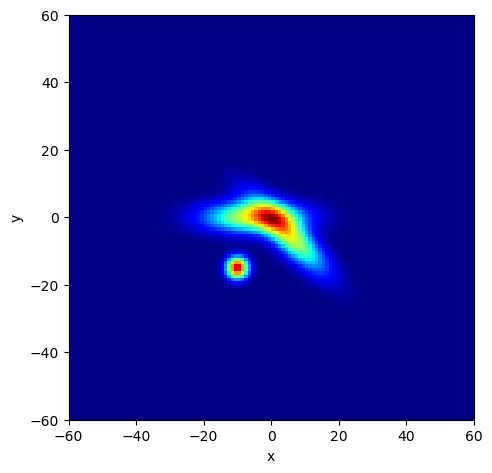

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(gridx, gridy, original_distrib, cmap="jet")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
# fig.savefig("example_gauss_distrib.png", dpi=600)

### Histograms

In [26]:
# Rotate grid-xy applying rotation matrices
nr_angles = 5
angles = np.deg2rad(np.linspace(0, 180, nr_angles, endpoint=False))
rot_coords = rotates_distribution(coords, angles)
rot_matrices = [matrix_rotation(a) for a in angles]

# angles = np.linspace(0.0, 0.6, nr_angles)
# rot_matrices = np.array([matrix_to_scrn(kl) for kl in angles])
# rot_coords = rot_matrices @ coords

In [27]:
# Interpolate shrinked grid in a new rectangular grid
def process_for_interpolation(rot_coord):
    """."""
    z_val_itp = interpolate.griddata(
        rot_coord.T,
        original_distrib.ravel(),
        coords.T,
        method="linear",
        fill_value=0,
    )
    z_val_itp = z_val_itp.reshape(gridx.shape)
    proj1 = integrate.trapezoid(z_val_itp, dx=delta_y, axis=0)
    norm_const = integrate.trapezoid(proj1, dx=delta_x)
    return z_val_itp / norm_const


def parallel_process_for_interpolation(rot_coords, max_processes=4):
    """."""
    nr_processes = min(len(rot_coords), max_processes)

    with Pool(processes=nr_processes) as pool:
        hists = pool.map(process_for_interpolation, rot_coords)
    return np.array(hists)


hists = parallel_process_for_interpolation(rot_coords, max_processes=4)

In [28]:
nr_plots = hists.shape[0]
nr_cols = 2
nr_rows = int(np.ceil(nr_plots / nr_cols))
fig, axs = plt.subplots(
    nr_rows, nr_cols, sharex=True, sharey=True, figsize=(6, 3 * nr_rows)
)

axs = axs.flat
for i, ax in enumerate(axs):
    if i < nr_plots:
        ax.pcolormesh(gridx, gridy, hists[i], cmap="jet")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        angle = np.round(np.rad2deg(angles[i]))
        ax.set_title(rf"Rotated Distribution $\theta={angle}$")
        ax.set_aspect("equal")
    else:
        ax.axis("off")
fig.suptitle(f"Number of Projections: {nr_angles}")
fig.tight_layout()

### Projections

In [29]:
projs_x, bins_x, bins_size_x = get_projections(gridx, gridy, hists)

## Add noise to the distributions
for proj in projs_x:
    proj += np.random.randn(proj.size)*proj.max()*0.02 * 0
    proj[proj<0] = 0

# Normalize projection according to bin_size
projs_x_bin = []

for i, proj in enumerate(projs_x):
    projs_x_bin.append(proj * bins_size_x[i])

In [31]:
# plots the projection respect to each theta
nr_plots = len(projs_x)
nr_cols = 3
nr_rows = int(np.ceil(nr_plots / nr_cols))
fig, axs = plt.subplots(
    nr_rows, nr_cols, sharex=True, sharey=True, figsize=(7, 3 * nr_rows)
)

axs = axs.flat
for i, ax in enumerate(axs):
    if i < nr_plots:
        ax.grid(ls="--", alpha=0.5)
        ax.bar(
            bins_x[i][:-1],
            projs_x[i],
            width=bins_size_x[i],
            align="edge",
            zorder=2,
            color="C0",
        )
        angle = np.round(np.rad2deg(angles[i]))
        ax.set_title(rf"Projection in x $(\theta={angle})$")
        ax.set_ylabel("count")
    else:
        ax.axis("off")

if nr_plots > nr_cols:
    axs[nr_plots - nr_cols].set_xlabel("x")
axs[nr_plots - 1].set_xlabel("x")

fig.suptitle(f"Number of Projections: {nr_angles}")
fig.tight_layout()
# fig.savefig(f"projections_j{nr_angles}.png", dpi=600)

### Create Reconstruction Object

In [35]:
dist_rec = DistribReconstruction(
    matrices=rot_matrices,
    projs=projs_x_bin,
    projs_bins=bins_x,
)

dist_rec.params.lagmult_fancy_init = False
dist_rec.params.sing_vals_cutoff_ratio = 1e-3
print(dist_rec)

Params:
    nrpts_per_bin = 3
    lagmult_fancy_init = False
    loop_num_iterations = 100
    min_lagmult_change = 1e-05
    gain_per_iteration = 1.00
    max_lagmult_step = 1.00
    min_relative_chi2 = 1e-05
    sing_vals_cutoff_ratio = 0.001

number of projections: 15
number of bins per projection: [79, 83, 83, 82, 79, 75, 70, 63, 53, 44, 47, 56, 66, 71, 76]
gridx num points = 237
gridy num points = 174
total num points = 41238



In [33]:
# Plot region for reconstruction
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

fig, ax = plot_lines(dist_rec.raveled_lines, fig=fig, ax=ax, color="k", lw=0.3, alpha=0.4)
fig, ax = plot_convex(dist_rec.main_convex, fig=fig, ax=ax, ms=0, color="C0")
ax.set_aspect("equal")
# ax.set_xlim(-40, 40)
# ax.set_ylim(-40, 40)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
fig.suptitle(f"Number of Projections: {nr_angles}")
# fig.savefig(f"convex_grid_j{nr_angles}.png", dpi=600)

Text(0.5, 0.98, 'Number of Projections: 15')

### Get Distribution

In [36]:
dist_rec.reconstruct_distribution()

0001/0100 -> max. rel. change=1.00e+00, nr_svs=0918/1027, rel. chi_square=5.89e+05
0002/0100 -> max. rel. change=5.18e-01, nr_svs=0918/1027, rel. chi_square=7.96e+04
0003/0100 -> max. rel. change=3.58e-01, nr_svs=0918/1027, rel. chi_square=1.07e+04
0004/0100 -> max. rel. change=2.81e-01, nr_svs=0918/1027, rel. chi_square=1.44e+03
0005/0100 -> max. rel. change=2.41e-01, nr_svs=0918/1027, rel. chi_square=1.89e+02
0006/0100 -> max. rel. change=2.23e-01, nr_svs=0918/1027, rel. chi_square=2.40e+01
0007/0100 -> max. rel. change=2.19e-01, nr_svs=0917/1027, rel. chi_square=2.82e+00
0008/0100 -> max. rel. change=2.53e-01, nr_svs=0913/1027, rel. chi_square=3.05e-01
0009/0100 -> max. rel. change=5.54e-01, nr_svs=0906/1027, rel. chi_square=3.14e-02
0010/0100 -> max. rel. change=1.22e+00, nr_svs=0896/1027, rel. chi_square=3.09e-03
0011/0100 -> max. rel. change=7.25e+00, nr_svs=0873/1027, rel. chi_square=2.90e-04
0012/0100 -> max. rel. change=5.94e+00, nr_svs=0773/1027, rel. chi_square=2.68e-05
0013

In [37]:
convergence = np.array(dist_rec.convergence_info)

fig, ax = plt.subplots(1, 1)

ax.plot(convergence[:, 0], convergence[:, 1], "o")
ay = ax.twinx()
ay.plot(convergence[:, 0], convergence[:, 3], 'ko')
ay.set_yscale('log')
ax.set_yscale("log")

ax.grid(ls="--", alpha=0.5)
ay.set_ylabel(r'Relative $\chi^2$')
ax.set_xlabel("iteration")
ax.set_ylabel(r"$\Delta\lambda_{jm}^{(i+1)}\,\,/\,\,\lambda_{jm}^{(i)}$", color='C0')
ax.tick_params(axis='y', colors='C0', which='both')
ax.spines['left'].set_color('C0')
ay.spines['left'].set_visible(False)
# np.savetxt(f"convergence_j{nr_angles}.txt", convergence)

In [38]:
%matplotlib qt5

# Compare simulated distribution with reconstructed one

fig, (ax, ay) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))

fig, ax = plot_distrib_in_grid(
    fig, ax, gridx, gridy, original_distrib, 1, cmap="jet"
)
ax.set_title("Original Distribution")

distrib = dist_rec.get_model_distribution().reshape(dist_rec.model_gridx.shape)
fig, ay = plot_lines(dist_rec.raveled_lines, fig=fig, ax=ay, color="k", lw=0.1, alpha=0.5)
fig, ay = plot_distrib_in_grid(
    fig, ay, dist_rec.model_gridx, dist_rec.model_gridy, distrib, 1, cmap="jet"
)

ay.set_title("Recontruction from Projections")

fig.suptitle(f"Number of projections: {nr_angles}")
# fig.savefig(f"reconstruction_j{nr_angles}.png", dpi=600)

Text(0.5, 0.98, 'Number of projections: 15')

In [39]:
# Compare values of langrange multiplier
fig, ax = plt.subplots(1, 1)

init_lagmults = dist_rec.init_lagmults
for j in range(nr_angles):
    ax.plot(dist_rec.lagmults[j], "-o", label=f"proj. {j}")
    ax.plot(np.log(dist_rec.projs_meas[j]), "-", color=f'C{j:d}')
    ax.plot(init_lagmults[j], "--", color=f'C{j:d}')
ax.set_yscale("linear")
ax.set_title("Lagrange Multipliers")
ax.grid(ls="--", alpha=0.5)
ax.legend()

In [40]:
# Compare projections of simulated distribution and reconstructed one
projs_calc = dist_rec.get_model_projections()
nr_projs = dist_rec.nr_projs

fig, axs = plt.subplots(1, nr_projs, figsize=(4*nr_projs, 4))

for i, ax in enumerate(axs):
    x_plot = ScreenProcess.bin_to_position(bins_x[i])
    ax.plot(x_plot, projs_x_bin[i], "-o", label="meas.")
    ax.plot(x_plot, projs_calc[i], "-o", label="calc.")
    ax.legend()
    ax.set_title(f"Projection {i}")
    ax.set_xlabel("x")
    ax.grid(ls="--", alpha=0.5)
axs[0].set_ylabel("y")

Text(0, 0.5, 'y')

### Compare Distributions

In [40]:
# Interpolates initial distribution in polygon's centroid
hist = original_distrib.copy()
grid_area = delta_x * delta_y
points = np.vstack([gridx.ravel(), gridy.ravel()]).T
hist_values = hist.ravel()

ini_distrib_itp = interpolate_distrib_in_cvxs(
    hist_values, centroids, areas, points
)

In [47]:
print("difference in convexes:")
diff = difference_btw_distributions(ini_distrib_itp, rec_distrib_val, areas)
print(diff)

difference in convexes:
0.3922534599909907


In [48]:
diff = difference_btw_distributions(
    hist.ravel(), rec_distrib_itp.ravel(), grid_areas
)
print("difference in regular grid:")
print(diff)
# np.savetxt(f"diff_btw_distribs_j{nr_angles}.txt", [nr_angles, diff])

difference in regular grid:
0.39540726091931583
